In [70]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
from collections import defaultdict
import seaborn as sns
from itertools import combinations

In [47]:
%load_ext autoreload
%autoreload 2

In [2]:
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

### Load Data

In [3]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')
interv_df = pd.read_csv('outputs/interventions.csv')
analysis_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')
pilot_trans_df_small = pd.read_csv('outputs/pilot_transitions.csv')
pilot_trans_df = pd.read_csv('outputs/pilot_transitions_5months.csv')

In [4]:
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Get Transition Probabilities

In [5]:
def get_transition_probabilities(beneficiaries, transitions, min_support=5):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}
user_probs, sup = get_transition_probabilities([pilot_user_ids[0]], pilot_trans_df)

all_probs = pd.DataFrame(columns = ['user_id'] + list(user_probs.keys()))
for user_id in tqdm.tqdm(pilot_user_ids):
        user_probs, sup = get_transition_probabilities([user_id], pilot_trans_df)
        user_probs['user_id'] = user_id
        all_probs = all_probs.append(user_probs, ignore_index=True)

100%|██████████| 23008/23008 [03:25<00:00, 112.20it/s]


In [6]:
print('Non-missing passive tuples (on which clustering can happen)')
print(all_probs[(~all_probs['P(L, N, L)'].isna()) & (~all_probs['P(H, N, L)'].isna())].shape)   
all_probs = pd.merge(all_probs, df[['user_id', 'cluster']])


Non-missing passive tuples (on which clustering can happen)
(10159, 9)


### Clustering freshly on Complete Dataset


In [60]:
from sklearn.cluster import KMeans
from clustering import kmeans_missing
import numpy as np

USE_KMEANS_MISSING = False
n_clusters = 40
COLS_FOR_KMEANS = ['P(L, N, L)', 'P(H, N, L)']
prob_cols = [col for col in all_probs.columns if col.startswith('P')]
bootstrap_count = 1000

big_cluster_probs = pd.DataFrame(columns=[ 'count', 'cluster', 'bs'] + prob_cols)

for bs in tqdm.tqdm(range(bootstrap_count)):
    if USE_KMEANS_MISSING:
        X = all_probs.copy()
        out =  kmeans_missing(X[COLS_FOR_KMEANS], n_clusters, random_state=bs) 
        labels, centroids, X_hat, kmeans_new, _, _ = out
        X = pd.DataFrame(X_hat, columns=X.columns)
    else:
        is_missing_passive = all_probs[COLS_FOR_KMEANS].isna().sum(axis=1).astype(bool)
        X = all_probs[~is_missing_passive]
        kmeans = KMeans(n_clusters=n_clusters, random_state=bs).fit(X[COLS_FOR_KMEANS])
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
    X['fitted_cluster'] = labels
    X = X.drop(columns=['cluster'])
    
    new_cluster_transition_probabilities = pd.DataFrame(columns=[ 'count', 'cluster', 'bs'] + prob_cols)

    for i in range(n_clusters):
        cluster_beneficiaries = X[X['fitted_cluster'] == i]
        cluster_b_user_ids = cluster_beneficiaries['user_id']
        probs, _ = get_transition_probabilities(cluster_b_user_ids, pilot_trans_df, min_support=3)
        probs['cluster'] = i
        probs['bs'] = bs
        probs['count'] = len(cluster_b_user_ids)
        new_cluster_transition_probabilities = new_cluster_transition_probabilities.append(probs, ignore_index=True)
    
    for i in range(4, 8):
        if i % 2 == 0:
            curr_col = prob_cols[i]
            new_cluster_transition_probabilities[curr_col] = new_cluster_transition_probabilities[curr_col].fillna(new_cluster_transition_probabilities[curr_col].mean())
        else:
            new_cluster_transition_probabilities[prob_cols[i]] = 1 - new_cluster_transition_probabilities[prob_cols[i - 1]]
    for i in range(4):
        if i % 2 == 0:
            curr_col = prob_cols[i]
            est_col = prob_cols[i + 4]
            diff_col = new_cluster_transition_probabilities[curr_col] - new_cluster_transition_probabilities[est_col]
            diff_col = diff_col.fillna(diff_col.mean())
            new_cluster_transition_probabilities[curr_col] = diff_col + new_cluster_transition_probabilities[est_col]
            new_cluster_transition_probabilities.loc[new_cluster_transition_probabilities[curr_col] >= 1, curr_col] = 1
        else:
            new_cluster_transition_probabilities[prob_cols[i]] = 1 - new_cluster_transition_probabilities[prob_cols[i - 1]]
    big_cluster_probs = big_cluster_probs.append(new_cluster_transition_probabilities)

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  0%|          | 1/1000 [00:00<15:55,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  0%|          | 2/1000 [00:01<16:25,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

  2%|▏         | 21/1000 [00:19<14:55,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  2%|▏         | 22/1000 [00:20<14:50,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  2%|▏         | 23/1000 [00:21<14:48,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

  4%|▍         | 42/1000 [00:38<14:33,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  4%|▍         | 43/1000 [00:39<14:39,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  4%|▍         | 44/1000 [00:40<14:37,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

  6%|▋         | 63/1000 [00:57<14:12,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  6%|▋         | 64/1000 [00:58<14:14,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  6%|▋         | 65/1000 [00:59<14:13,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

  8%|▊         | 84/1000 [01:16<13:52,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  8%|▊         | 85/1000 [01:17<13:57,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
  9%|▊         | 86/1000 [01:18<14:03,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

 10%|█         | 105/1000 [01:35<13:32,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 11%|█         | 106/1000 [01:36<13:29,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 11%|█         | 107/1000 [01:37<13:48,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 13%|█▎        | 126/1000 [01:56<14:25,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 13%|█▎        | 127/1000 [01:57<14:01,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 13%|█▎        | 128/1000 [01:58<13:43,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 15%|█▍        | 147/1000 [02:15<13:12,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 15%|█▍        | 148/1000 [02:16<13:19,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 15%|█▍        | 149/1000 [02:17<13:16,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 17%|█▋        | 168/1000 [02:34<12:31,  1.11it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 17%|█▋        | 169/1000 [02:35<12:29,  1.11it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 17%|█▋        | 170/1000 [02:36<12:29,  1.11it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 19%|█▉        | 189/1000 [02:54<12:31,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 19%|█▉        | 190/1000 [02:55<12:30,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 19%|█▉        | 191/1000 [02:55<12:19,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 21%|██        | 210/1000 [03:13<11:59,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 21%|██        | 211/1000 [03:14<11:53,  1.11it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 21%|██        | 212/1000 [03:15<11:55,  1.10it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 23%|██▎       | 231/1000 [03:32<12:02,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 23%|██▎       | 232/1000 [03:33<11:51,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 23%|██▎       | 233/1000 [03:34<11:47,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 25%|██▌       | 252/1000 [03:52<11:36,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 25%|██▌       | 253/1000 [03:53<11:31,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 25%|██▌       | 254/1000 [03:53<11:22,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 27%|██▋       | 273/1000 [04:11<11:23,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 27%|██▋       | 274/1000 [04:12<11:13,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 28%|██▊       | 275/1000 [04:13<11:08,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 29%|██▉       | 294/1000 [04:30<11:05,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 30%|██▉       | 295/1000 [04:31<10:56,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 30%|██▉       | 296/1000 [04:32<10:50,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 32%|███▏      | 315/1000 [04:50<10:33,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 32%|███▏      | 316/1000 [04:51<10:29,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 32%|███▏      | 317/1000 [04:52<10:24,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 34%|███▎      | 336/1000 [05:09<10:22,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 34%|███▎      | 337/1000 [05:10<10:14,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 34%|███▍      | 338/1000 [05:11<10:14,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 36%|███▌      | 357/1000 [05:29<09:59,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 36%|███▌      | 358/1000 [05:30<09:54,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 36%|███▌      | 359/1000 [05:31<10:01,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 38%|███▊      | 378/1000 [05:48<09:50,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 38%|███▊      | 379/1000 [05:49<09:46,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 38%|███▊      | 380/1000 [05:50<09:38,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 40%|███▉      | 399/1000 [06:08<09:17,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 40%|████      | 400/1000 [06:09<09:12,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 40%|████      | 401/1000 [06:10<09:09,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 42%|████▏     | 420/1000 [06:28<09:14,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 42%|████▏     | 421/1000 [06:29<09:13,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 42%|████▏     | 422/1000 [06:30<09:07,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 44%|████▍     | 441/1000 [06:48<08:55,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 44%|████▍     | 442/1000 [06:49<08:53,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 44%|████▍     | 443/1000 [06:50<08:55,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 46%|████▌     | 462/1000 [07:08<08:34,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 46%|████▋     | 463/1000 [07:09<08:29,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 46%|████▋     | 464/1000 [07:10<08:31,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 48%|████▊     | 483/1000 [07:30<09:10,  1.06s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 48%|████▊     | 484/1000 [07:31<08:48,  1.02s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 48%|████▊     | 485/1000 [07:31<08:27,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 50%|█████     | 504/1000 [07:51<08:04,  1.02it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 50%|█████     | 505/1000 [07:52<07:52,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 51%|█████     | 506/1000 [07:53<07:38,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 52%|█████▎    | 525/1000 [08:12<07:48,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 53%|█████▎    | 526/1000 [08:13<07:38,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 53%|█████▎    | 527/1000 [08:13<07:35,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 55%|█████▍    | 546/1000 [08:33<08:20,  1.10s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 55%|█████▍    | 547/1000 [08:34<08:13,  1.09s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 55%|█████▍    | 548/1000 [08:35<07:57,  1.06s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 57%|█████▋    | 567/1000 [08:54<06:45,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 57%|█████▋    | 568/1000 [08:55<06:50,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 57%|█████▋    | 569/1000 [08:56<06:54,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 59%|█████▉    | 588/1000 [09:14<06:27,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 59%|█████▉    | 589/1000 [09:15<06:23,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 59%|█████▉    | 590/1000 [09:16<06:28,  1.05it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 61%|██████    | 609/1000 [09:35<06:04,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 61%|██████    | 610/1000 [09:36<06:07,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 61%|██████    | 611/1000 [09:37<06:16,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 63%|██████▎   | 630/1000 [09:56<05:54,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 63%|██████▎   | 631/1000 [09:57<05:49,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 63%|██████▎   | 632/1000 [09:58<05:58,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 65%|██████▌   | 651/1000 [10:17<05:23,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 65%|██████▌   | 652/1000 [10:18<05:21,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 65%|██████▌   | 653/1000 [10:19<05:26,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 67%|██████▋   | 672/1000 [10:38<05:18,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 67%|██████▋   | 673/1000 [10:39<05:08,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 67%|██████▋   | 674/1000 [10:40<05:01,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 69%|██████▉   | 693/1000 [10:58<05:03,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 69%|██████▉   | 694/1000 [10:59<05:15,  1.03s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 70%|██████▉   | 695/1000 [11:00<05:14,  1.03s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 71%|███████▏  | 714/1000 [11:19<04:22,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 72%|███████▏  | 715/1000 [11:20<04:28,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 72%|███████▏  | 716/1000 [11:21<04:34,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 74%|███████▎  | 735/1000 [11:40<04:21,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 74%|███████▎  | 736/1000 [11:41<04:14,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 74%|███████▎  | 737/1000 [11:42<04:13,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 76%|███████▌  | 756/1000 [12:01<03:58,  1.02it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 76%|███████▌  | 757/1000 [12:02<03:58,  1.02it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 76%|███████▌  | 758/1000 [12:03<03:56,  1.02it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 78%|███████▊  | 777/1000 [12:21<03:37,  1.02it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 78%|███████▊  | 778/1000 [12:22<03:36,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 78%|███████▊  | 779/1000 [12:23<03:40,  1.00it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 80%|███████▉  | 798/1000 [12:44<03:20,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 80%|███████▉  | 799/1000 [12:45<03:19,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 80%|████████  | 800/1000 [12:46<03:18,  1.01it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 82%|████████▏ | 819/1000 [13:04<02:57,  1.02it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 82%|████████▏ | 820/1000 [13:05<02:54,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 82%|████████▏ | 821/1000 [13:06<02:53,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 84%|████████▍ | 840/1000 [13:24<02:35,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 84%|████████▍ | 841/1000 [13:25<02:34,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 84%|████████▍ | 842/1000 [13:26<02:28,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 86%|████████▌ | 861/1000 [13:44<02:15,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 86%|████████▌ | 862/1000 [13:45<02:10,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 86%|████████▋ | 863/1000 [13:46<02:05,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 88%|████████▊ | 882/1000 [14:04<01:54,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 88%|████████▊ | 883/1000 [14:05<01:49,  1.07it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 88%|████████▊ | 884/1000 [14:06<01:46,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 90%|█████████ | 903/1000 [14:24<01:29,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 90%|█████████ | 904/1000 [14:25<01:28,  1.09it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 90%|█████████ | 905/1000 [14:26<01:27,  1.08it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 92%|█████████▏| 924/1000 [14:45<01:15,  1.00it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 92%|█████████▎| 925/1000 [14:46<01:15,  1.00s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 93%|█████████▎| 926/1000 [14:47<01:13,  1.00it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 94%|█████████▍| 945/1000 [15:05<00:53,  1.02it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 95%|█████████▍| 946/1000 [15:06<00:52,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 95%|█████████▍| 947/1000 [15:07<00:51,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 97%|█████████▋| 966/1000 [15:26<00:32,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 97%|█████████▋| 967/1000 [15:27<00:31,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 97%|█████████▋| 968/1000 [15:28<00:30,  1.03it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

 99%|█████████▊| 987/1000 [15:46<00:13,  1.00s/it]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 99%|█████████▉| 988/1000 [15:47<00:11,  1.04it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
 99%|█████████▉| 989/1000 [15:48<00:10,  1.06it/s]<ipython-input-60-ee6866690c78>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [79]:
big_cluster_probs[(big_cluster_probs['bs'].isin([1,2, 5, 8, 10, 12])) &
                 (big_cluster_probs['cluster']==3)][['P(L, I, L)', 'cluster', 'bs']]

,"P(L, I, L)",cluster,bs
3,0.878788,3.0,1.0
3,0.857143,3.0,2.0
3,0.780488,3.0,5.0
3,0.400000,3.0,8.0
3,0.830189,3.0,10.0
3,0.520000,3.0,12.0


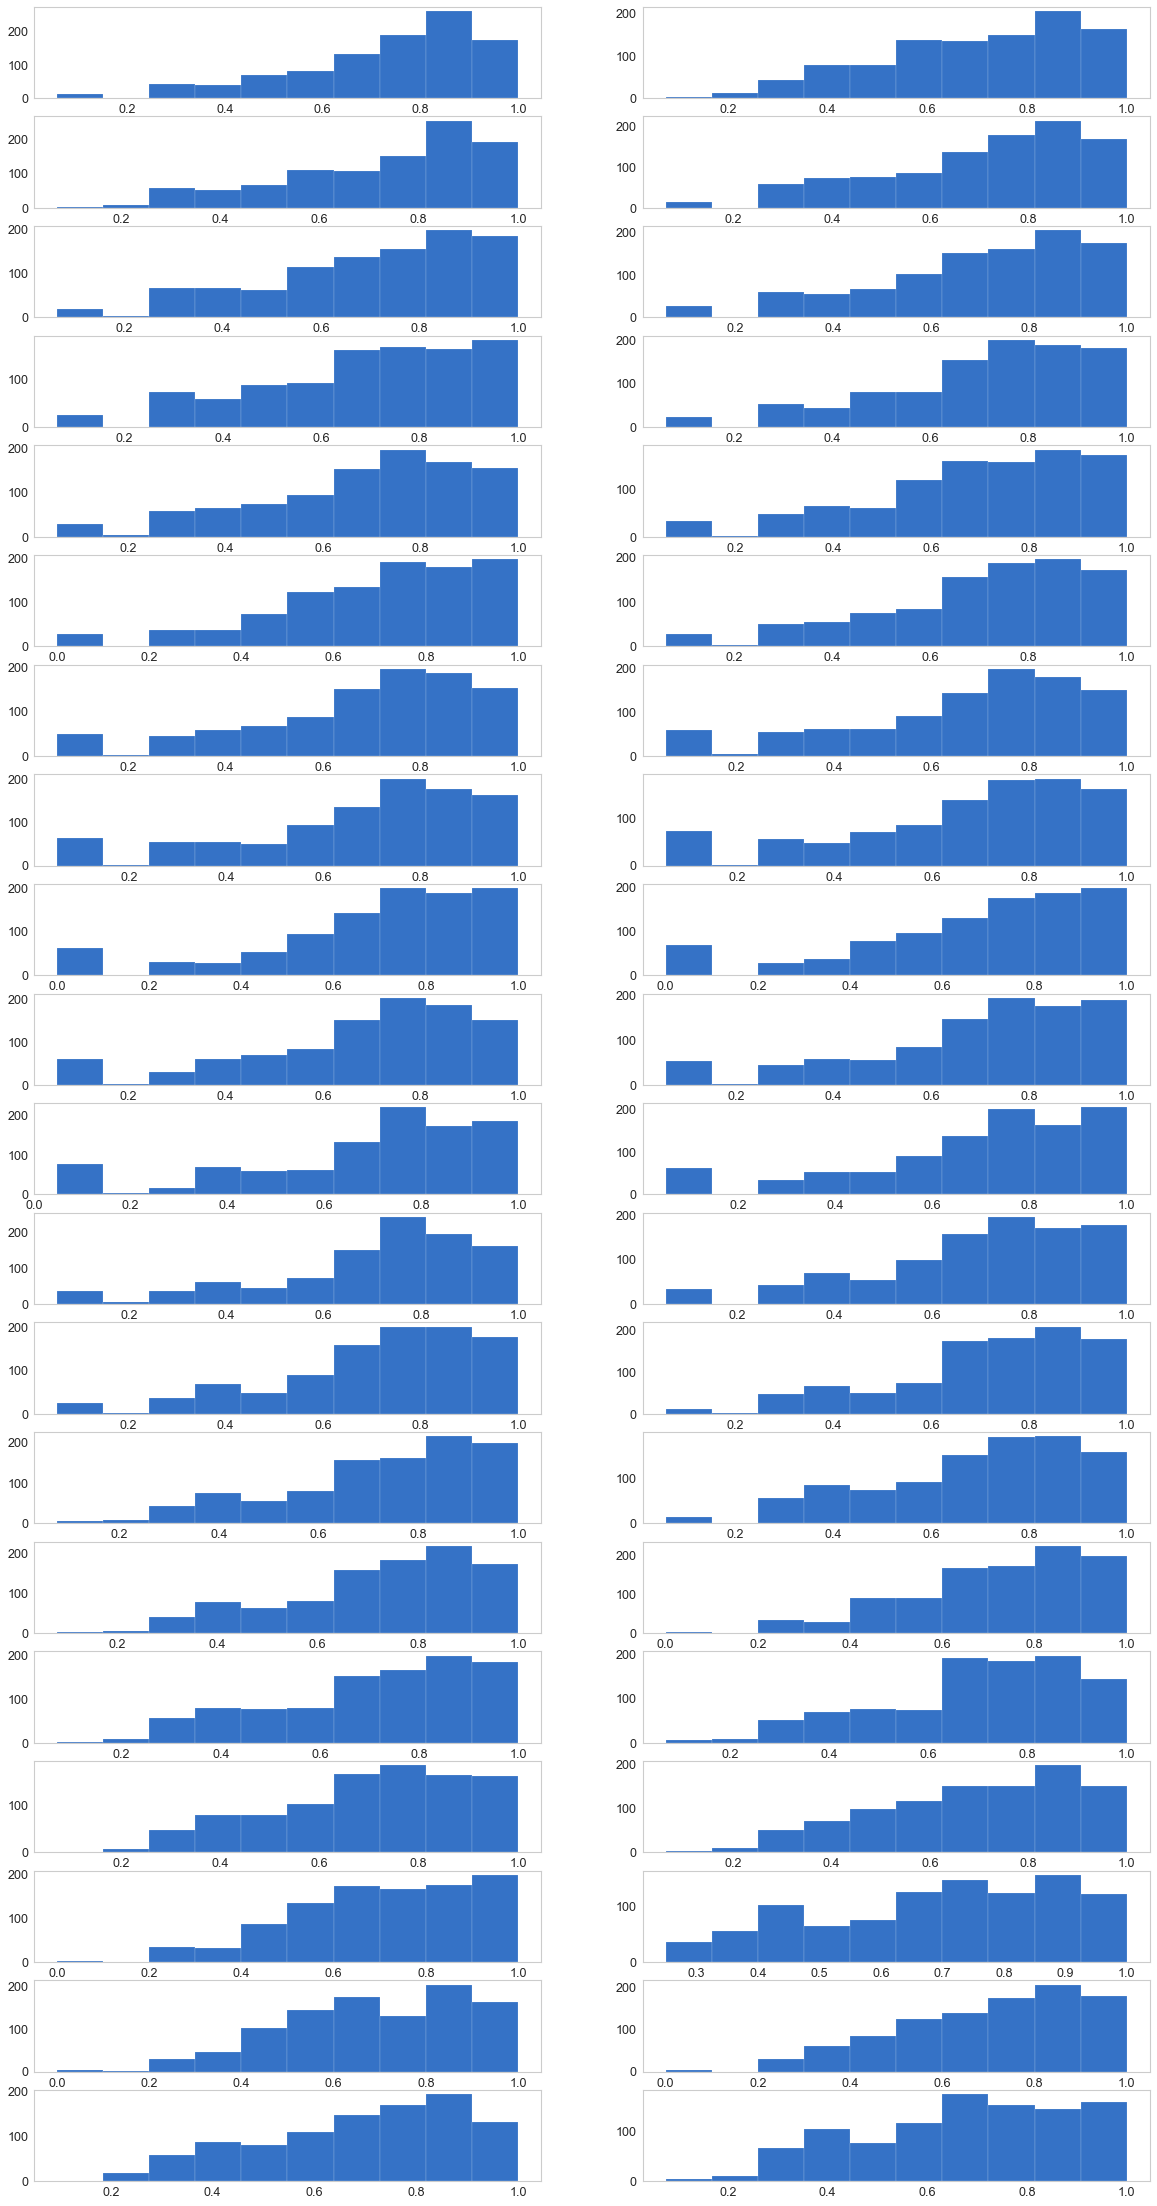

In [71]:
plt.figure(figsize=(20,40))
sns.set_style("whitegrid", {'axes.grid' : False})

for prob_col in prob_cols[:1]:
    for cluster in range(n_clusters):
        plt.subplot(20, 2, cluster+1)
        plt.hist(big_cluster_probs[big_cluster_probs['cluster']==cluster][prob_col] )
        

In [93]:
from sklearn.cluster import KMeans
from clustering import kmeans_missing
import numpy as np

USE_KMEANS_MISSING = False
n_clusters = 40
COLS_FOR_KMEANS = ['P(L, N, L)', 'P(H, N, L)']
prob_cols = [col for col in all_probs.columns if col.startswith('P')]
bootstrap_count = 200
SAMPLING_FRAC = 0.8

if USE_KMEANS_MISSING:
    X = all_probs.copy()
    out =  kmeans_missing(X[COLS_FOR_KMEANS], n_clusters, random_state=bs) 
    labels, centroids, X_hat, kmeans_new, _, _ = out
    X = pd.DataFrame(X_hat, columns=X.columns)
else:
    is_missing_passive = all_probs[COLS_FOR_KMEANS].isna().sum(axis=1).astype(bool)
    X = all_probs[~is_missing_passive]
    kmeans = KMeans(n_clusters=n_clusters, random_state=bs).fit(X[COLS_FOR_KMEANS])
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

X['fitted_cluster'] = labels
X = X.drop(columns=['cluster'])
base_df = X.copy()

big_cluster_probs = pd.DataFrame(columns=[ 'count', 'cluster', 'bs'] + prob_cols)
big_user_probs = pd.DataFrame(columns=[ 'user_id', 'bs'] + prob_cols)
for bs in tqdm.tqdm(range(bootstrap_count)):
    if USE_KMEANS_MISSING:
        X = all_probs.copy().sample(frac=SAMPLING_FRAC)
        out =  kmeans_missing(X[COLS_FOR_KMEANS], n_clusters, random_state=bs) 
        labels, centroids, X_hat, kmeans_new, _, _ = out
        X = pd.DataFrame(X_hat, columns=X.columns)
    else:
        is_missing_passive = all_probs[COLS_FOR_KMEANS].isna().sum(axis=1).astype(bool)
        X = all_probs[~is_missing_passive].sample(frac=SAMPLING_FRAC)
        kmeans = KMeans(n_clusters=n_clusters, random_state=bs).fit(X[COLS_FOR_KMEANS])
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
    X['fitted_cluster'] = labels
    X = X.drop(columns=['cluster'])
    
    new_cluster_transition_probabilities = pd.DataFrame(columns=[ 'count', 'cluster', 'bs'] + prob_cols)

    for i in range(n_clusters):
        cluster_beneficiaries = X[X['fitted_cluster'] == i]
        cluster_b_user_ids = cluster_beneficiaries['user_id']
        probs, _ = get_transition_probabilities(cluster_b_user_ids, pilot_trans_df, min_support=3)
        probs['cluster'] = i
        probs['bs'] = bs
        probs['count'] = len(cluster_b_user_ids)
        new_cluster_transition_probabilities = new_cluster_transition_probabilities.append(probs, ignore_index=True)
    
    for i in range(4, 8):
        if i % 2 == 0:
            curr_col = prob_cols[i]
            new_cluster_transition_probabilities[curr_col] = new_cluster_transition_probabilities[curr_col].fillna(new_cluster_transition_probabilities[curr_col].mean())
        else:
            new_cluster_transition_probabilities[prob_cols[i]] = 1 - new_cluster_transition_probabilities[prob_cols[i - 1]]
    for i in range(4):
        if i % 2 == 0:
            curr_col = prob_cols[i]
            est_col = prob_cols[i + 4]
            diff_col = new_cluster_transition_probabilities[curr_col] - new_cluster_transition_probabilities[est_col]
            diff_col = diff_col.fillna(diff_col.mean())
            new_cluster_transition_probabilities[curr_col] = diff_col + new_cluster_transition_probabilities[est_col]
            new_cluster_transition_probabilities.loc[new_cluster_transition_probabilities[curr_col] >= 1, curr_col] = 1
        else:
            new_cluster_transition_probabilities[prob_cols[i]] = 1 - new_cluster_transition_probabilities[prob_cols[i - 1]]
    big_cluster_probs = big_cluster_probs.append(new_cluster_transition_probabilities)
    user_probs = new_cluster_transition_probabilities.set_index('cluster').loc[X['fitted_cluster']][prob_cols]
    user_probs['user_id'] = X['user_id'].values
    user_probs['bs'] = bs
    
    big_user_probs = big_user_probs.append(user_probs, ignore_index=True)
big_user_probs

<ipython-input-93-43dc5602d83a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['fitted_cluster'] = labels
100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


,user_id,bs,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)"
0,2404693.0,0,0.500000,0.500000,0.444444,0.555556,0.421288,0.578712,0.274333,0.725667
1,2386545.0,0,0.876543,0.123457,0.375000,0.625000,0.827113,0.172887,0.606618,0.393382
2,2396140.0,0,0.782609,0.217391,0.640000,0.360000,0.709327,0.290673,0.319906,0.680094
3,2405052.0,0,0.267370,0.732630,0.425000,0.575000,0.199125,0.800875,0.249477,0.750523
4,2393286.0,0,0.666667,0.333333,0.185185,0.814815,0.826786,0.173214,0.078234,0.921766
...,...,...,...,...,...,...,...,...,...,...
1625395,2408395.0,199,1.000000,0.000000,0.387097,0.612903,0.500000,0.500000,0.201609,0.798391
1625396,2405607.0,199,0.666667,0.333333,0.190476,0.809524,0.525942,0.474058,0.301814,0.698186
1625397,2387991.0,199,0.853659,0.146341,0.500000,0.500000,0.846014,0.153986,0.349749,0.650251
1625398,2399668.0,199,0.883721,0.116279,0.393939,0.606061,0.823971,0.176029,0.257107,0.742893


In [94]:
big_user_probs[big_user_probs['user_id']==2385613]

,user_id,bs,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)"
3143,2385613.0,0,0.529412,0.470588,0.281250,0.718750,0.618880,0.381120,0.224016,0.775984
9381,2385613.0,1,0.571429,0.428571,0.380952,0.619048,0.575515,0.424485,0.210160,0.789840
18851,2385613.0,2,0.714286,0.285714,0.347826,0.652174,0.542254,0.457746,0.205891,0.794109
29050,2385613.0,3,0.625000,0.375000,0.285714,0.714286,0.538825,0.461175,0.208664,0.791336
35947,2385613.0,4,0.600000,0.400000,0.277778,0.722222,0.575505,0.424495,0.210790,0.789210
...,...,...,...,...,...,...,...,...,...,...
1588350,2385613.0,195,0.800000,0.200000,0.357143,0.642857,0.536119,0.463881,0.208721,0.791279
1596928,2385613.0,196,1.000000,0.000000,0.357143,0.642857,0.536455,0.463545,0.209373,0.790627
1602084,2385613.0,197,0.625000,0.375000,0.315789,0.684211,0.606128,0.393872,0.219111,0.780889
1614448,2385613.0,198,0.588235,0.411765,0.290323,0.709677,0.619506,0.380494,0.224210,0.775790


In [99]:
base_df

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",fitted_cluster
2,2385613.0,NaN,NaN,NaN,NaN,0.571429,0.428571,0.214286,0.785714,18
7,2385618.0,NaN,NaN,NaN,NaN,0.833333,0.166667,0.071429,0.928571,16
8,2385619.0,NaN,NaN,NaN,NaN,0.714286,0.285714,0.214286,0.785714,37
10,2385621.0,NaN,NaN,NaN,NaN,0.428571,0.571429,0.357143,0.642857,13
12,2385623.0,NaN,NaN,NaN,NaN,0.785714,0.214286,0.571429,0.428571,1
...,...,...,...,...,...,...,...,...,...,...
22993,2409127.0,NaN,NaN,NaN,NaN,0.875000,0.125000,0.076923,0.923077,16
22994,2409128.0,NaN,NaN,NaN,NaN,0.800000,0.200000,0.333333,0.666667,19
22997,2409131.0,NaN,NaN,NaN,NaN,1.000000,0.000000,0.200000,0.800000,24
22999,2409133.0,NaN,NaN,NaN,NaN,0.928571,0.071429,0.142857,0.857143,11


In [100]:
data_df = pd.merge(big_user_probs, base_df[['user_id', 'fitted_cluster']])
data_df

,user_id,bs,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",fitted_cluster
0,2404693.0,0,0.500000,0.500000,0.444444,0.555556,0.421288,0.578712,0.274333,0.725667,2
1,2404693.0,1,0.538462,0.461538,0.428571,0.571429,0.421142,0.578858,0.274085,0.725915,2
2,2404693.0,4,0.583333,0.416667,0.230769,0.769231,0.420518,0.579482,0.273852,0.726148,2
3,2404693.0,5,0.461538,0.538462,0.375000,0.625000,0.420034,0.579966,0.275722,0.724278,2
4,2404693.0,7,0.538462,0.461538,0.272727,0.727273,0.420916,0.579084,0.274991,0.725009,2
...,...,...,...,...,...,...,...,...,...,...,...
1625395,2398629.0,192,0.625000,0.375000,0.764706,0.235294,0.664432,0.335568,0.525316,0.474684,10
1625396,2398629.0,194,0.714286,0.285714,0.571429,0.428571,0.663339,0.336661,0.477692,0.522308,10
1625397,2398629.0,195,0.565217,0.434783,0.538462,0.461538,0.660837,0.339163,0.530047,0.469953,10
1625398,2398629.0,197,0.640000,0.360000,0.590909,0.409091,0.648707,0.351293,0.470236,0.529764,10


### Visualize spread around centroids within a cluster

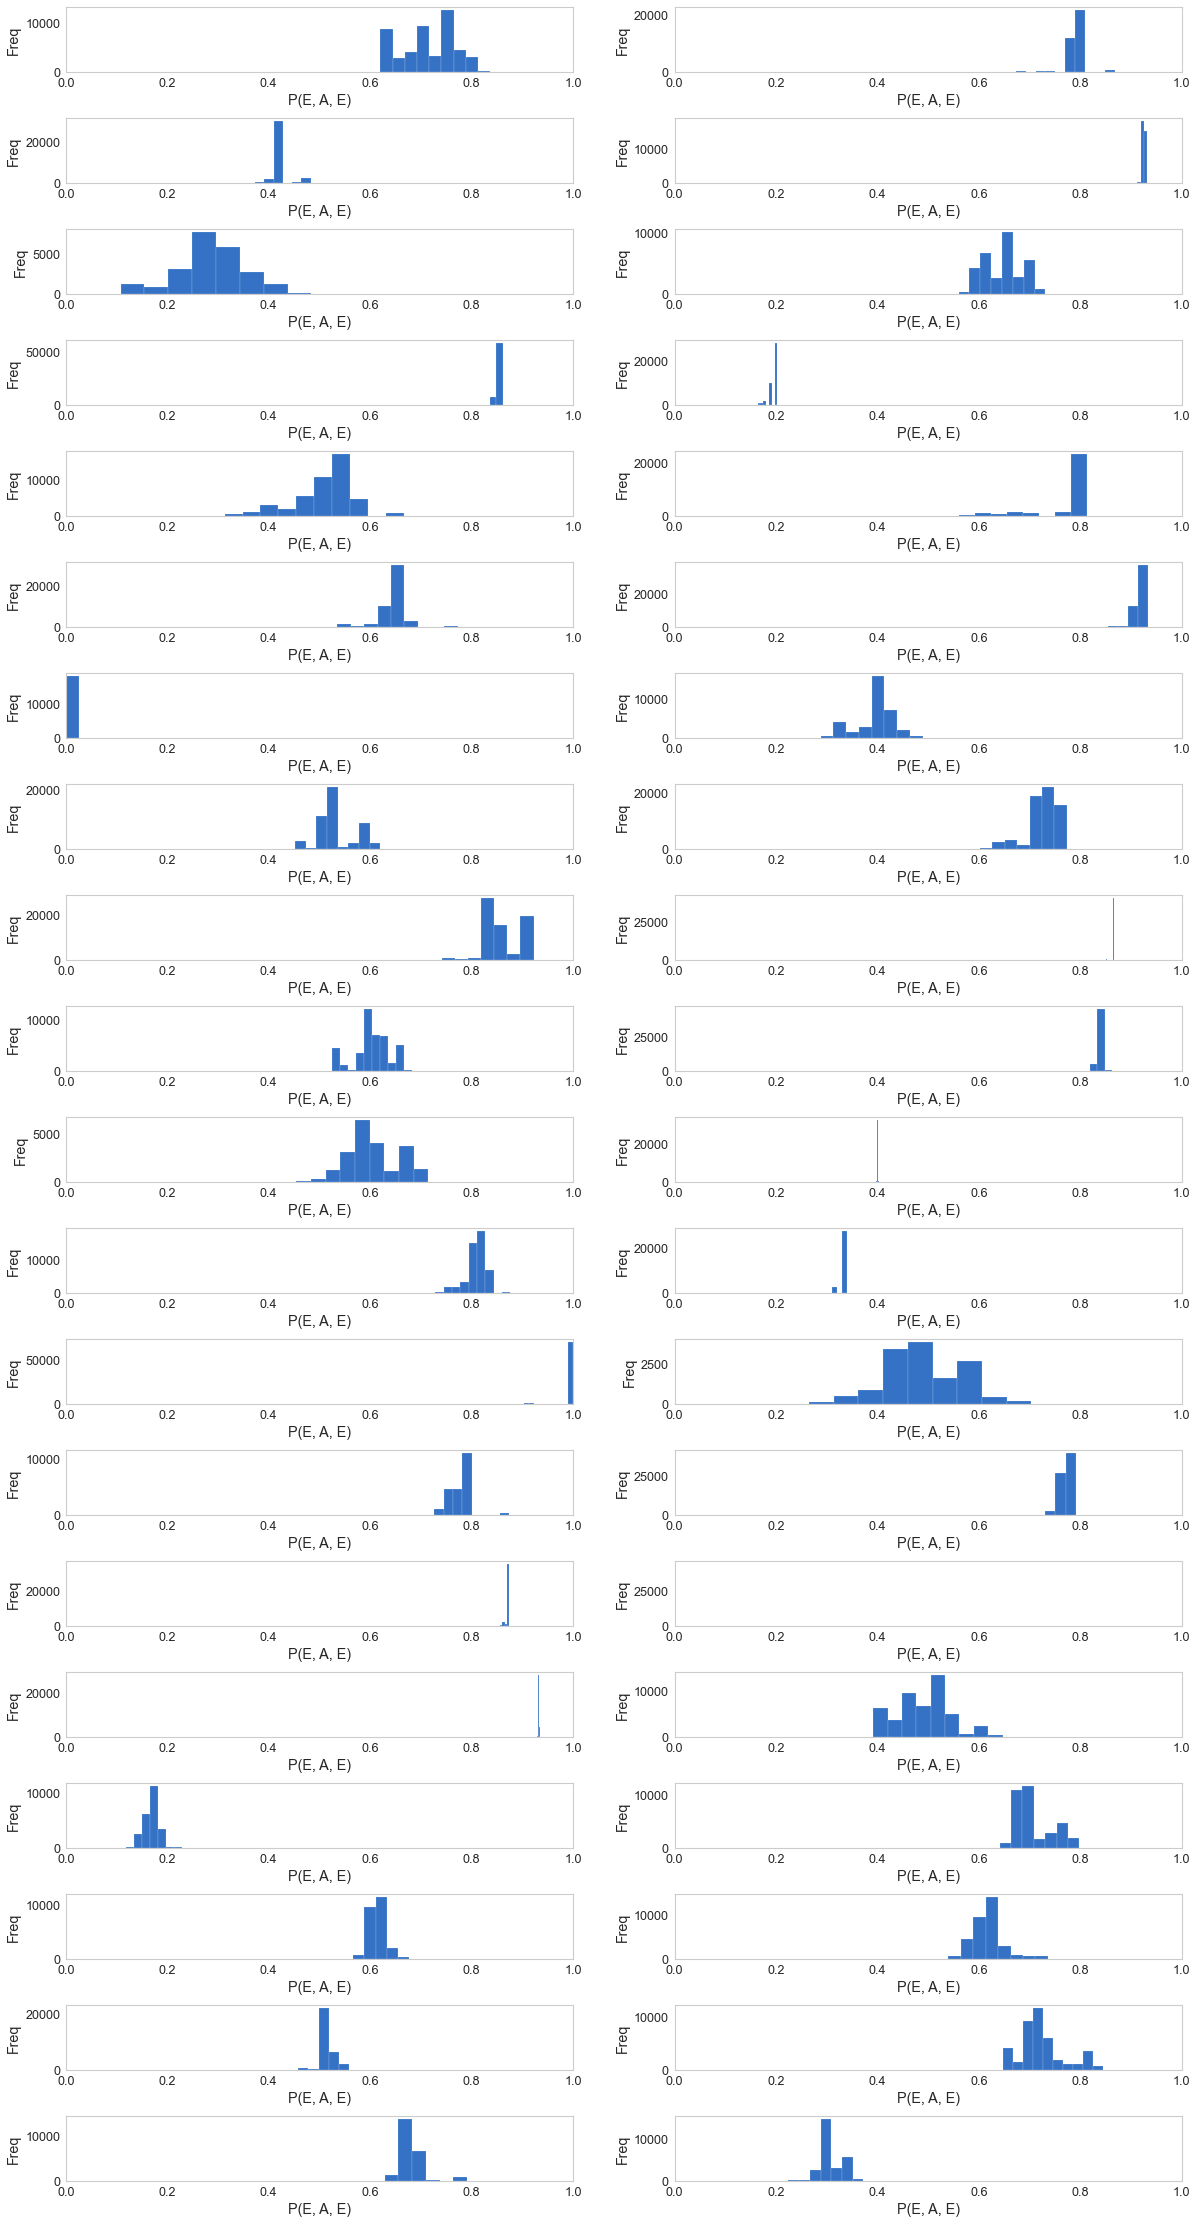

In [107]:
plt.figure(figsize=(20,40))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(data_df[data_df.fitted_cluster==cluster]['P(L, N, L)'], bins=10)
    
    plt.xlim(0, 1)
    plt.xlabel('P(E, A, E)')
    plt.ylabel('Freq')
    plt.subplots_adjust(
                    hspace=0.7, 
                    )
plt.show()



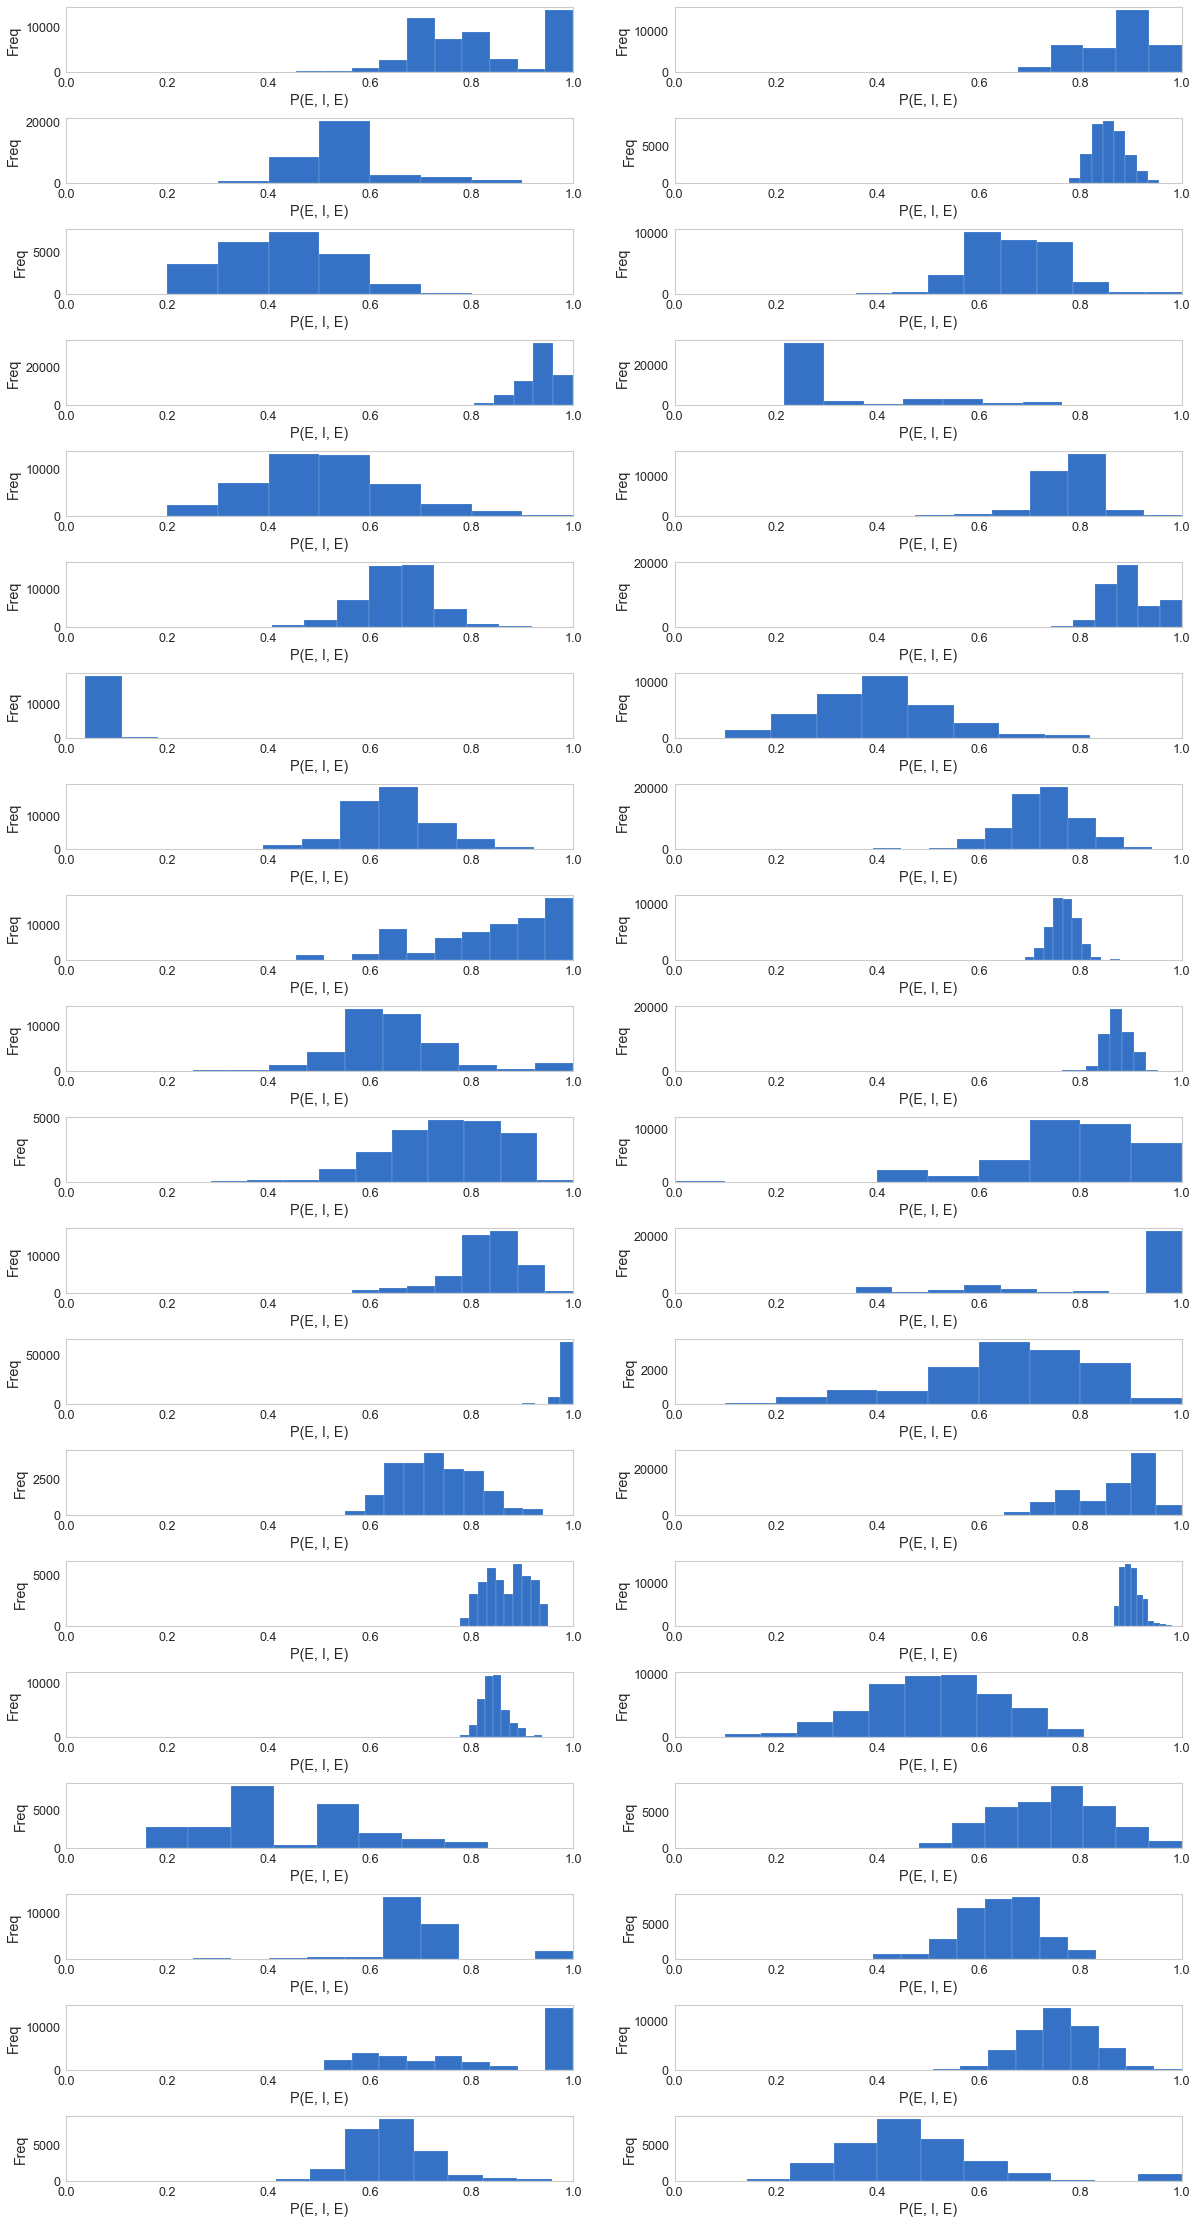

In [106]:
plt.figure(figsize=(20,40))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(data_df[data_df.fitted_cluster==cluster]['P(L, I, L)'], bins=10)
    plt.xlim(0, 1)
    plt.xlabel('P(E, I, E)')
    plt.ylabel('Freq')
    plt.subplots_adjust(
                    hspace=0.7, 
                    )
plt.show()



In [108]:
data_df

,user_id,bs,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",fitted_cluster
0,2404693.0,0,0.500000,0.500000,0.444444,0.555556,0.421288,0.578712,0.274333,0.725667,2
1,2404693.0,1,0.538462,0.461538,0.428571,0.571429,0.421142,0.578858,0.274085,0.725915,2
2,2404693.0,4,0.583333,0.416667,0.230769,0.769231,0.420518,0.579482,0.273852,0.726148,2
3,2404693.0,5,0.461538,0.538462,0.375000,0.625000,0.420034,0.579966,0.275722,0.724278,2
4,2404693.0,7,0.538462,0.461538,0.272727,0.727273,0.420916,0.579084,0.274991,0.725009,2
...,...,...,...,...,...,...,...,...,...,...,...
1625395,2398629.0,192,0.625000,0.375000,0.764706,0.235294,0.664432,0.335568,0.525316,0.474684,10
1625396,2398629.0,194,0.714286,0.285714,0.571429,0.428571,0.663339,0.336661,0.477692,0.522308,10
1625397,2398629.0,195,0.565217,0.434783,0.538462,0.461538,0.660837,0.339163,0.530047,0.469953,10
1625398,2398629.0,197,0.640000,0.360000,0.590909,0.409091,0.648707,0.351293,0.470236,0.529764,10


In [143]:
data_df[data_df.user_id==2398629]

,user_id,bs,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",fitted_cluster
1625236,2398629.0,5,0.583333,0.416667,0.777778,0.222222,0.672500,0.327500,0.529678,0.470322,10
1625237,2398629.0,6,0.692308,0.307692,0.500000,0.500000,0.652762,0.347238,0.472070,0.527930,10
1625238,2398629.0,7,0.625000,0.375000,0.636364,0.363636,0.649718,0.350282,0.471306,0.528694,10
1625239,2398629.0,8,0.666667,0.333333,0.590909,0.409091,0.650954,0.349046,0.474119,0.525881,10
1625240,2398629.0,9,0.592593,0.407407,0.526316,0.473684,0.649789,0.350211,0.472071,0.527929,10
...,...,...,...,...,...,...,...,...,...,...,...
1625395,2398629.0,192,0.625000,0.375000,0.764706,0.235294,0.664432,0.335568,0.525316,0.474684,10
1625396,2398629.0,194,0.714286,0.285714,0.571429,0.428571,0.663339,0.336661,0.477692,0.522308,10
1625397,2398629.0,195,0.565217,0.434783,0.538462,0.461538,0.660837,0.339163,0.530047,0.469953,10
1625398,2398629.0,197,0.640000,0.360000,0.590909,0.409091,0.648707,0.351293,0.470236,0.529764,10


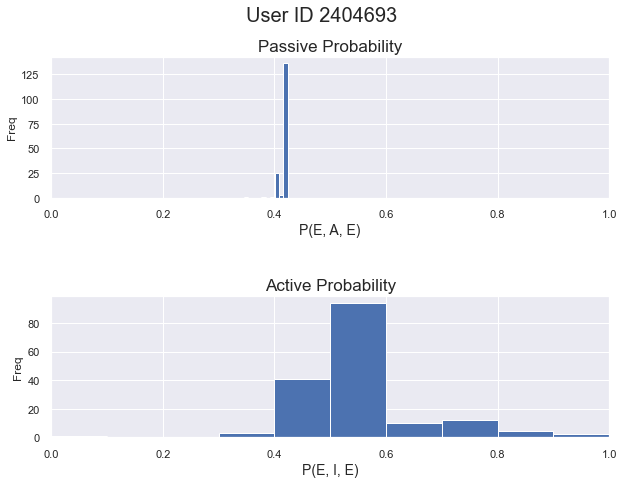

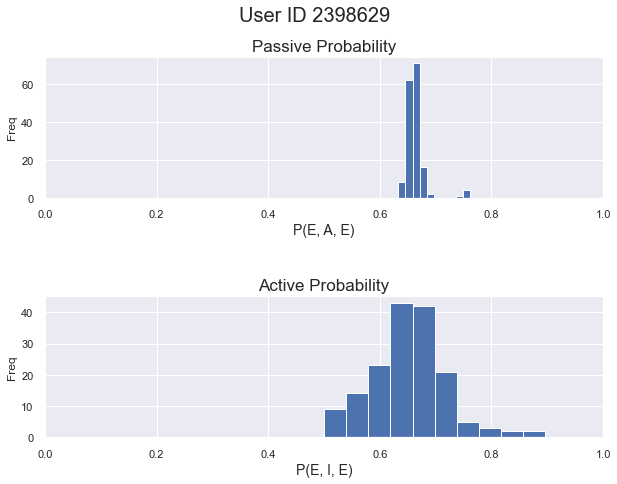

In [129]:
import seaborn as sns
sns.set()

plt.figure(figsize=(10, 7))
fig = plt.gcf()
fig.suptitle(f'User ID {2404693}', fontsize=20)
plt.subplot(2, 1, 1)
plt.hist(data_df[data_df.user_id==2404693.0]['P(L, N, L)'], bins=10)
plt.xlim(0, 1)
plt.xlabel('P(E, A, E)', fontsize=14)
plt.ylabel('Freq')
plt.title('Passive Probability', fontsize=17)

plt.subplot(2, 1, 2)
plt.hist(data_df[data_df.user_id==2404693.0]['P(L, I, L)'], bins=10)
plt.xlim(0, 1)
plt.xlabel('P(E, I, E)', fontsize=14)
plt.ylabel('Freq')
plt.title('Active Probability', fontsize=17)

plt.subplots_adjust(hspace=0.7, 
                    )
plt.show()

plt.figure(figsize=(10, 7))
fig = plt.gcf()
fig.suptitle(f'User ID {2398629}', fontsize=20)

plt.subplot(2, 1, 1)
plt.hist(data_df[data_df.user_id==2398629]['P(L, N, L)'], bins=10)
plt.xlim(0, 1)
plt.xlabel('P(E, A, E)', fontsize=14)
plt.ylabel('Freq')
plt.title('Passive Probability', fontsize=17)

plt.subplot(2, 1, 2)
plt.hist(data_df[data_df.user_id==2398629]['P(L, I, L)'], bins=10)
plt.xlim(0, 1)
plt.xlabel('P(E, I, E)', fontsize=14)
plt.ylabel('Freq')
plt.title('Active Probability', fontsize=17)

plt.subplots_adjust(hspace=0.7, 
                    )


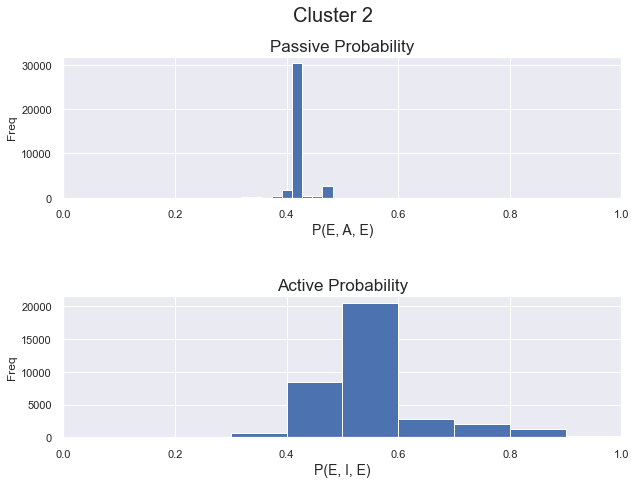

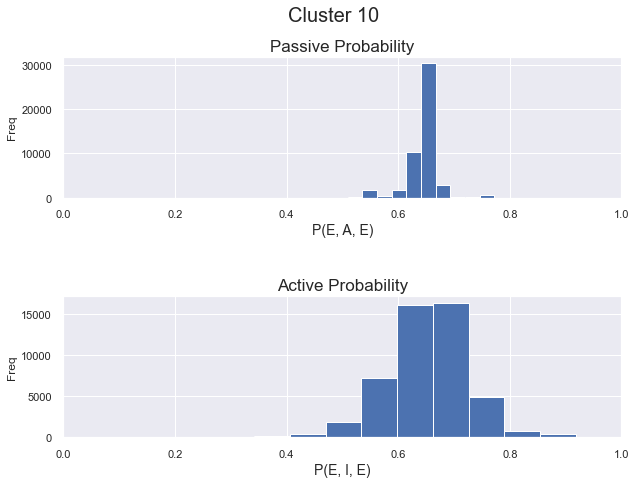

In [142]:
import seaborn as sns
sns.set()

plt.figure(figsize=(10, 7))
fig = plt.gcf()
fig.suptitle(f'Cluster 2', fontsize=20)
plt.subplot(2, 1, 1)
plt.hist(data_df[data_df.fitted_cluster==2]['P(L, N, L)'], bins=10)
plt.xlim(0, 1)
plt.xlabel('P(E, A, E)', fontsize=14)
plt.ylabel('Freq')
plt.title('Passive Probability', fontsize=17)

plt.subplot(2, 1, 2)
plt.hist(data_df[data_df.fitted_cluster==2]['P(L, I, L)'], bins=10)
plt.xlim(0, 1)
plt.xlabel('P(E, I, E)', fontsize=14)
plt.ylabel('Freq')
plt.title('Active Probability', fontsize=17)

plt.subplots_adjust(hspace=0.7, 
                    )
plt.show()

plt.figure(figsize=(10, 7))
fig = plt.gcf()
fig.suptitle(f'Cluster 10', fontsize=20)

plt.subplot(2, 1, 1)
plt.hist(data_df[data_df.fitted_cluster==10]['P(L, N, L)'], bins=10)
plt.xlim(0, 1)
plt.xlabel('P(E, A, E)', fontsize=14)
plt.ylabel('Freq')
plt.title('Passive Probability', fontsize=17)

plt.subplot(2, 1, 2)
plt.hist(data_df[data_df.fitted_cluster==10]['P(L, I, L)'], bins=10)
plt.xlim(0, 1)
plt.xlabel('P(E, I, E)', fontsize=14)
plt.ylabel('Freq')
plt.title('Active Probability', fontsize=17)

plt.subplots_adjust(hspace=0.7, 
                    )


### Train-val split strategy

80 % 20% -> A, B

clustering on A -> ylabels

SPlit A in 80% and 20% we will get A_train, A_test

classifier is trained on A_train, tested on A_tested -> 7%

train classifier on full A
use classifier to predict cluster centres for B using B features
get probablities using predicted cluster centres

for B: predicted TP and true transition TP



## Train -val Split

In [78]:
USE_KMEANS_MISSING = False
n_clusters = 40
SPLIT_FRAC = 0.8
print(f'Initally {all_probs.shape[0]} data points')
if USE_KMEANS_MISSING:
    print('Using kmeans missing')
    probs = all_probs[['user_id', 'P(L, N, L)', 'P(H, N, L)']]
else:
    print('Dropping missing passive probs points')
    probs = all_probs[['user_id', 'P(L, N, L)', 'P(H, N, L)']].dropna()

feat_cols = [f'feat-{i}' for i in range(pilot_static_features.shape[1])]
feats = pd.DataFrame(pilot_static_features, columns=feat_cols)
feats['user_id'] = pilot_user_ids
data_df = pd.merge(probs,
                      feats)
print(f'Modeling on {data_df.shape[0]} Data points ' )
n = data_df.shape[0]
shuffled = pd.Series(data_df.index).sample(frac=1).values
train_idx, test_idx = shuffled[:int(n*SPLIT_FRAC)],\
                               shuffled[int(n*SPLIT_FRAC):]
print('Train data points: ', len(train_idx))
print('Test data points: ', len(test_idx))

Initally 23003 data points
Dropping missing passive probs points
Modeling on 10159 Data points 
Train data points:  8127
Test data points:  2032


### CLustering on Train

In [79]:
from sklearn.cluster import KMeans
from clustering import kmeans_missing
import numpy as np


X = data_df.loc[train_idx][['P(L, N, L)', 'P(H, N, L)']]

X_feat = data_df.loc[train_idx][feat_cols]
if USE_KMEANS_MISSING:
    out =  kmeans_missing(X, n_clusters) 
    labels, centroids, X_hat, kmeans_new, _, _ = out
    X = pd.DataFrame(X_hat, columns=X.columns)
else:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

X['fitted_cluster'] = labels



### Visualize Train Clustering and Spread around Centroids within a cluster

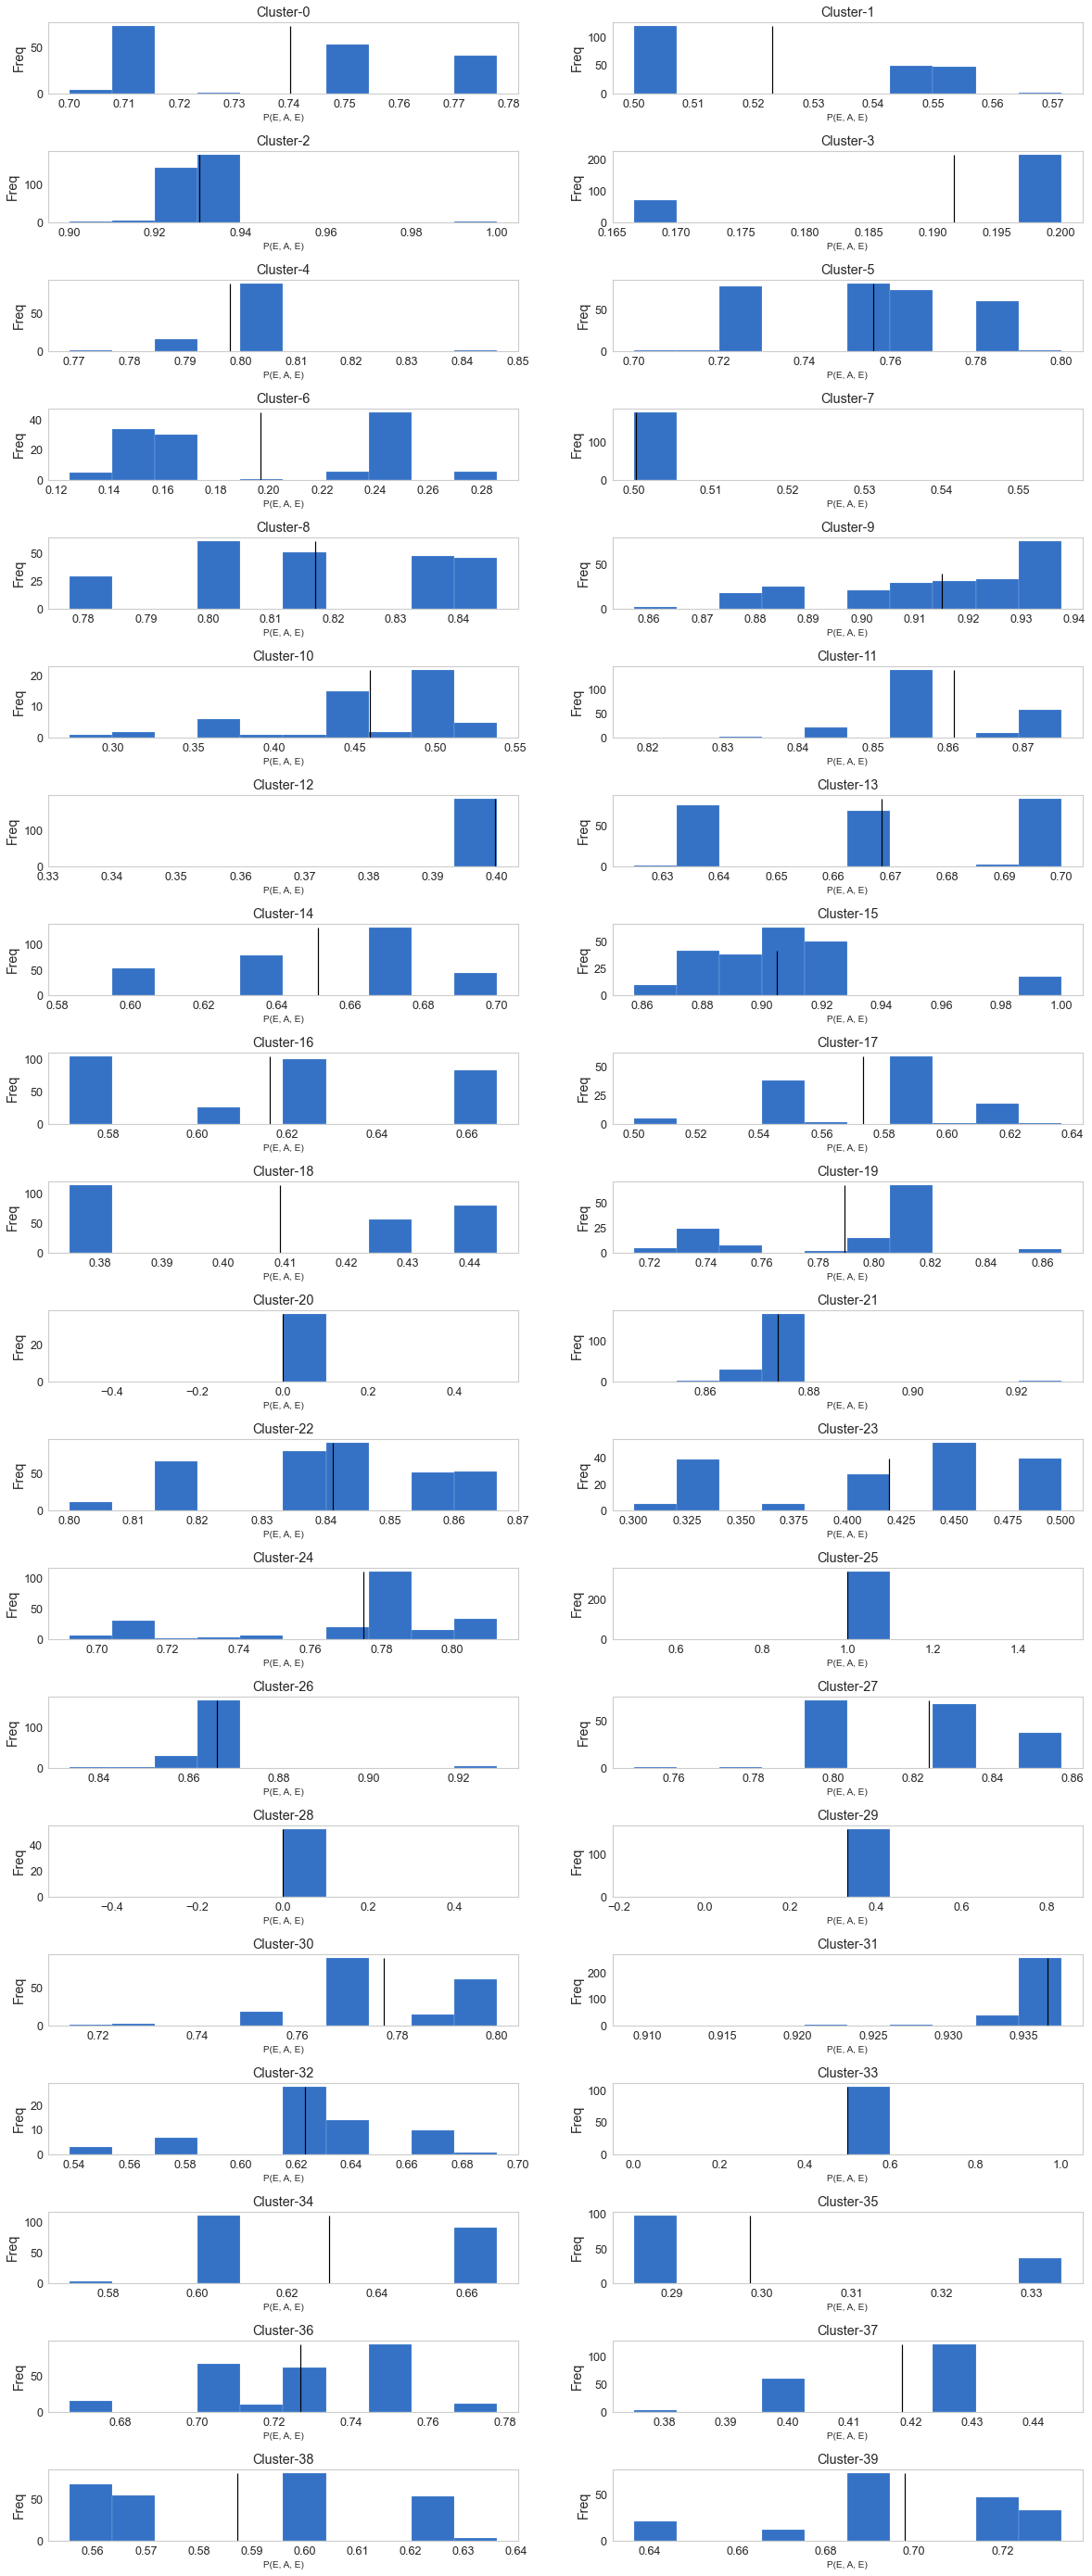

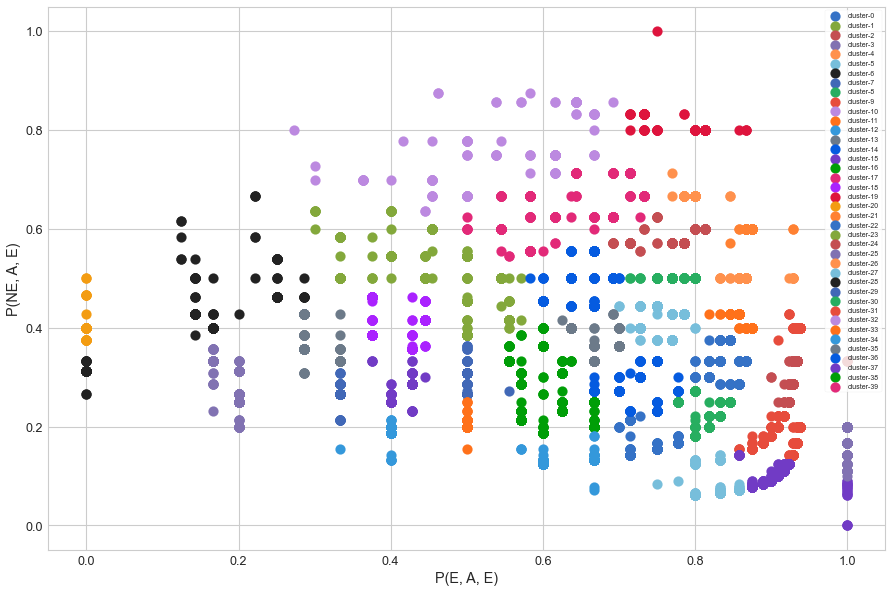

In [80]:
plt.figure(figsize=(20,50))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(X[X.fitted_cluster==cluster]['P(L, N, L)'])
    pred_prob = centroids[cluster, 0]
    
    ymax = X[X.fitted_cluster==cluster]['P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='black')
    plt.xlabel('P(E, A, E)', fontsize=10)
    plt.ylabel('Freq')
    plt.gca().set_title(f'Cluster-{cluster}')
    plt.subplots_adjust(
                    hspace=0.8, 
                    )

plt.show()

import seaborn as sns
plt.figure(figsize=(15, 10))
for cluster in range(n_clusters):
    plt.scatter(X[X['fitted_cluster']==cluster].iloc[:, 0],
                X[X['fitted_cluster']==cluster].iloc[:, 1],
                label=f'cluster-{cluster}', s=100)
plt.xlabel('P(E, A, E)')
plt.ylabel('P(NE, A, E)')
plt.grid(b=None)
plt.legend(fontsize=7)

### Learn Random Forest Classifier, get CV score

In [94]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X_feat, X['fitted_cluster']):
#     dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1, random_state=124)
#     dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=7, n_jobs=-1, random_state=124)
    dt_clf = LGBMClassifier(n_estimators=100, max_depth=3)
    dt_clf.fit(X_feat.iloc[train_index], X.iloc[train_index]['fitted_cluster'])
    print('test acc: ', dt_clf.score(X_feat.iloc[test_index], X.iloc[test_index]['fitted_cluster']), \
    'train acc: ', dt_clf.score(X_feat.iloc[train_index], X.iloc[train_index]['fitted_cluster']))

# dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1, random_state=124)
dt_clf = LGBMClassifier(n_estimators=100, max_depth=3)
dt_clf.fit(X_feat, X['fitted_cluster'])


test acc:  0.046740467404674045 train acc:  0.26595908321796646
test acc:  0.03997539975399754 train acc:  0.2673434856175973
test acc:  0.04120541205412054 train acc:  0.27041993539455467
test acc:  0.05350553505535055 train acc:  0.2719581602830334
test acc:  0.046740467404674045 train acc:  0.27411167512690354


LGBMClassifier(max_depth=3)

### Get predicted clusters, predicted probs, metrics

In [101]:
pred_clusters = dt_clf.predict(data_df.loc[test_idx, feat_cols])
print('unique predicted clusters: ', np.unique(pred_clusters))
pred_probs = X.groupby('fitted_cluster').mean().loc[pred_clusters]   
tru_probs = data_df.iloc[test_idx, 1:3]

print('RMSE from our classifier')
diff = (tru_probs.reset_index().iloc[:, 1:] - pred_probs.reset_index().iloc[:, 1:])
print(np.sqrt(np.square(diff).mean(axis=0)))
print()
print('RMSE from Random Classifier')
diff = tru_probs.reset_index().iloc[:, 1:] - np.random.uniform(0, 1, tru_probs.shape)
print(np.sqrt(np.square(diff).mean(axis=0)))


unique predicted clusters:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
RMSE from our classifier
P(L, N, L)    0.312133
P(H, N, L)    0.217511
dtype: float64

RMSE from Random Classifier
P(L, N, L)    0.404793
P(H, N, L)    0.364686
dtype: float64


### Visualize Spread in Validation data True Probablity, within assigned cluster

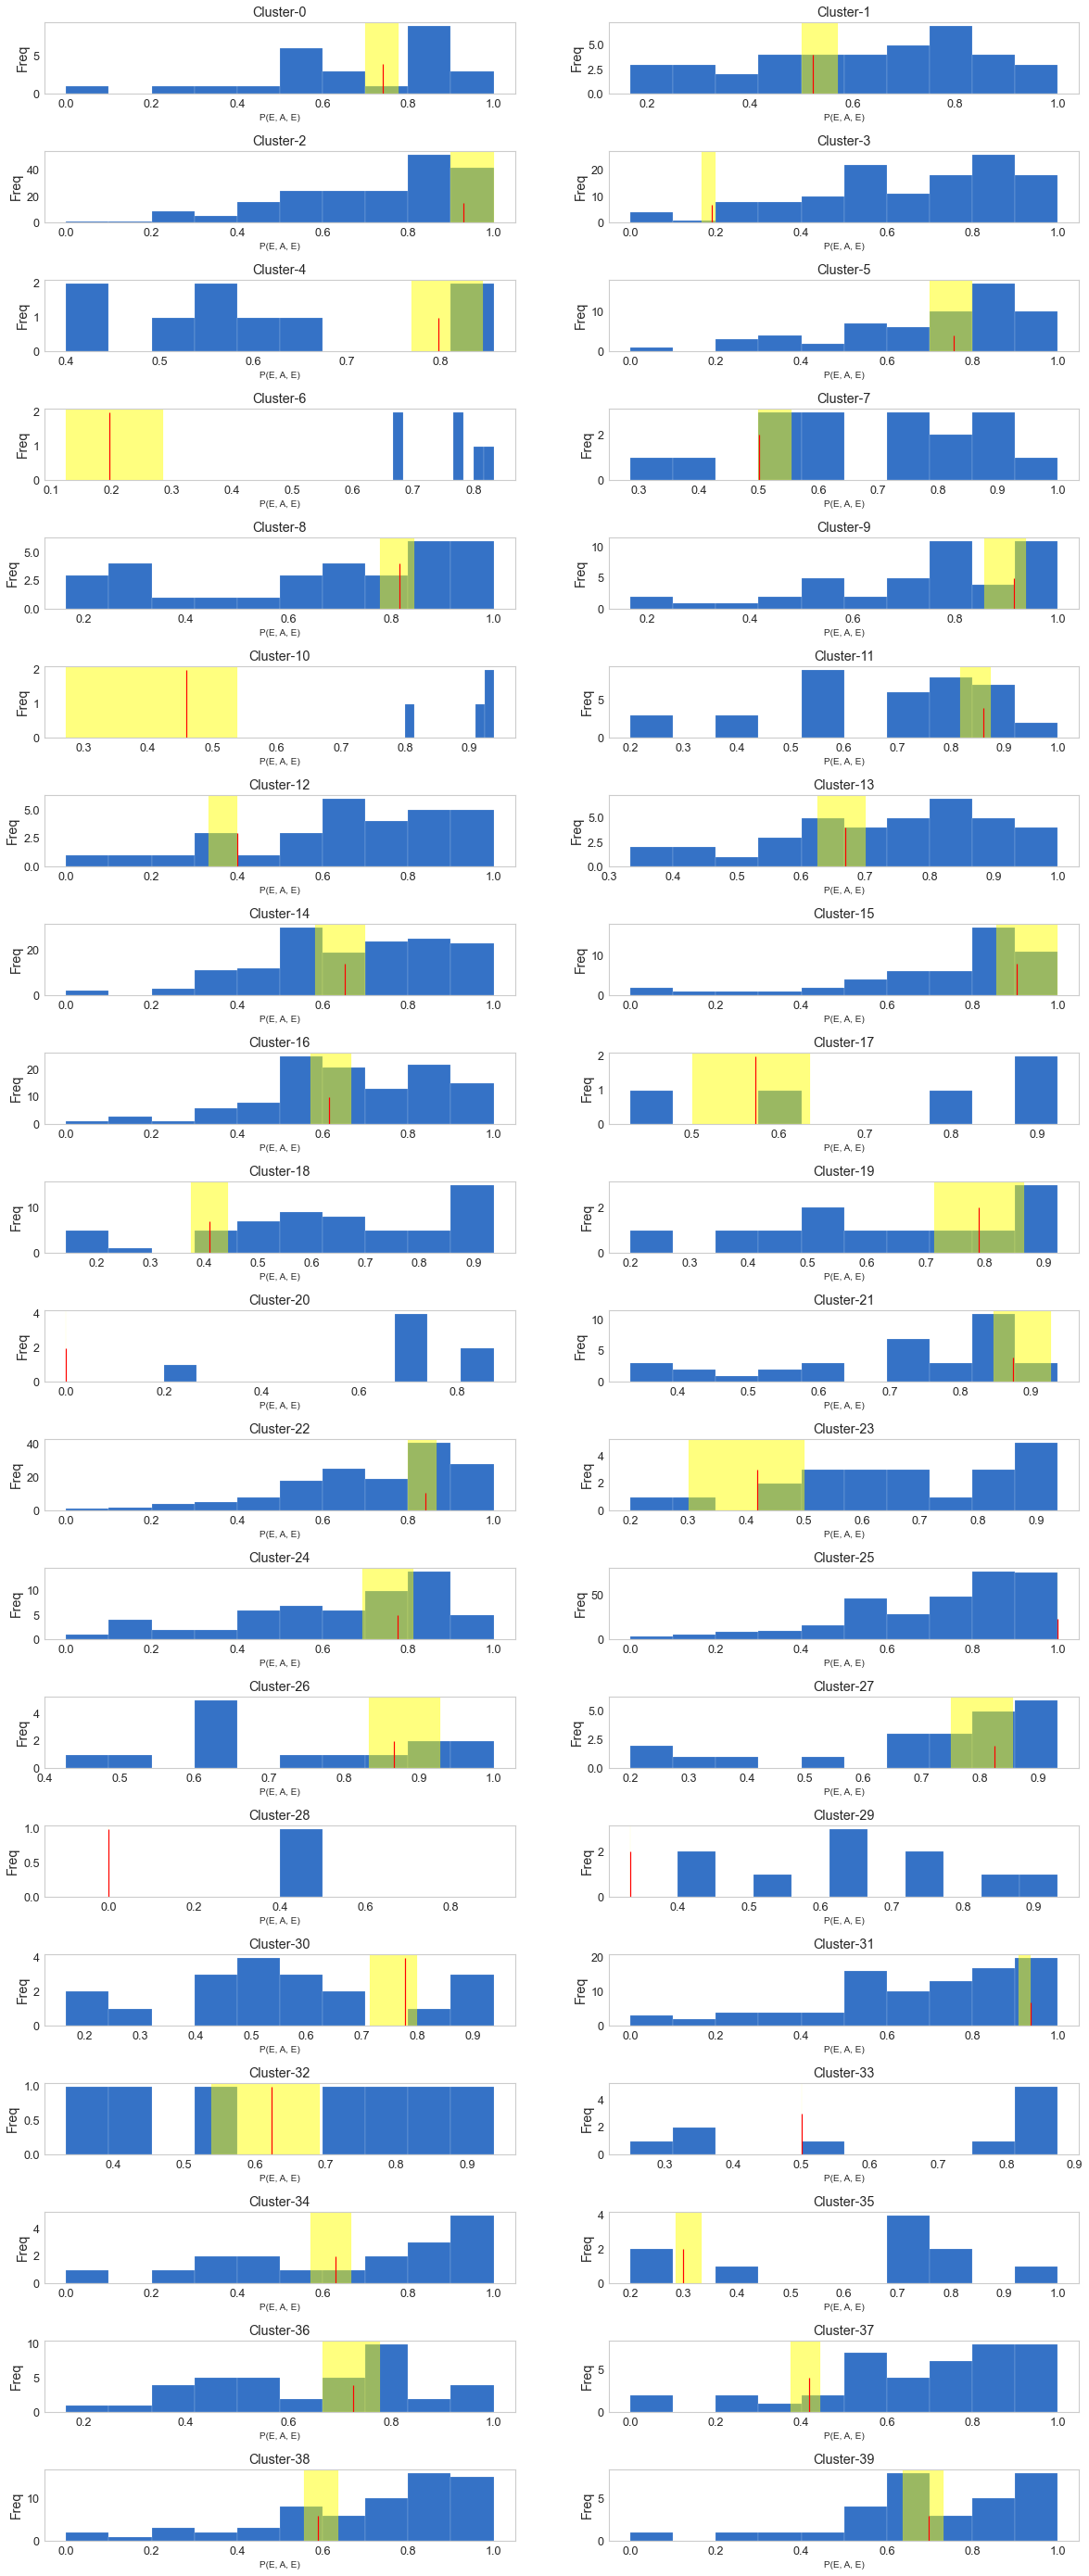

In [99]:
plot_df = pred_probs.reset_index()
plot_df['tru-P(L, N, L)'] = tru_probs.iloc[:, 0].values
plot_df['tru-P(H, N, L)'] = tru_probs.iloc[:, 1].values


plt.figure(figsize=(20,50))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(plot_df[plot_df.fitted_cluster==cluster]['tru-P(L, N, L)'])
    try:
        pred_prob = plot_df[plot_df.fitted_cluster==cluster]['P(L, N, L)'].iloc[0]
    except:
        print(f'Cluster {cluster} was never predicted, skipping')
        continue
    ymax = plot_df[plot_df.fitted_cluster==cluster]['tru-P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='red')

    plt.axvspan(xmin=X[X.fitted_cluster==cluster]['P(L, N, L)'].min(),
               xmax=X[X.fitted_cluster==cluster]['P(L, N, L)'].max(),
               ymin=0, ymax=ymax, alpha=0.5, color='yellow')
    plt.xlabel('P(E, A, E)', fontsize=10)
    plt.ylabel('Freq')
    plt.gca().set_title(f'Cluster-{cluster}')
    plt.subplots_adjust(
                    hspace=0.8, 
                    )
plt.show()